# Imports

In [ ]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Activation
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path_to_arrays = "/content/drive/My Drive/Computer Vision/Project/data/preprocessed/clipped_phy_stats"
path_train = os.path.join(path_to_arrays, "train_features.npy")
path_train_labels = os.path.join(path_to_arrays, "train_labels.npy")
train_features = np.load(path_train)
train_labels = np.load(path_train_labels)

path_val = os.path.join(path_to_arrays, "val_features.npy")
path_val_labels = os.path.join(path_to_arrays, "val_labels.npy")
val_features = np.load(path_val)
val_labels = np.load(path_val_labels)

path_test = os.path.join(path_to_arrays, "test_features.npy")
path_test_labels = os.path.join(path_to_arrays, "test_labels.npy")
test_features = np.load(path_test)
test_labels = np.load(path_test_labels)

In [ ]:
train_features.shape

(4301, 32, 32, 13)

## Normalize

In [ ]:
def normalize(train, data):
  for f in range(12):
    if f != 1 and f != 2: # don't normalize wind cos and sin
      feature = train[...,f]
      mean, std = np.mean(feature, axis=(0, 1, 2), keepdims=True), np.std(feature, axis=(0, 1, 2), keepdims=True) # get mean and std of "train"
      print(std, f)
      if std != 0:
        temp = data[...,f] # normalize "data" with std and mean from "train"
        temp = (temp - mean) / std
        data[...,f] = temp
  return data

val_features = normalize(train_features, val_features)
test_features = normalize(train_features, test_features)
train_features = normalize(train_features, train_features)

In [ ]:
val_features = normalize(train_features, val_features)
test_features = normalize(train_features, test_features)
train_features = normalize(train_features, train_features)

print(f"Std = {np.std(train_features[...,0], axis=(0, 1, 2), keepdims=True)}, Mean = {np.mean(train_features[...,0], axis=(0, 1, 2), keepdims=True)}")

[[[767.11807766]]] 0
[[[1.29028976]]] 3
[[[5.57093578]]] 4
[[[5.8862173]]] 5
[[[0.00236427]]] 6
[[[0.34863565]]] 7
[[[1.96908312]]] 8
[[[2014.71851002]]] 9
[[[126.19551652]]] 10
[[[19.45749409]]] 11
[[[767.11807766]]] 0
[[[1.29028976]]] 3
[[[5.57093578]]] 4
[[[5.8862173]]] 5
[[[0.00236427]]] 6
[[[0.34863565]]] 7
[[[1.96908312]]] 8
[[[2014.71851002]]] 9
[[[126.19551652]]] 10
[[[19.45749409]]] 11
[[[767.11807766]]] 0
[[[1.29028976]]] 3
[[[5.57093578]]] 4
[[[5.8862173]]] 5
[[[0.00236427]]] 6
[[[0.34863565]]] 7
[[[1.96908312]]] 8
[[[2014.71851002]]] 9
[[[126.19551652]]] 10
[[[19.45749409]]] 11
Std = [[[1.]]], Mean = [[[1.44037305e-17]]]


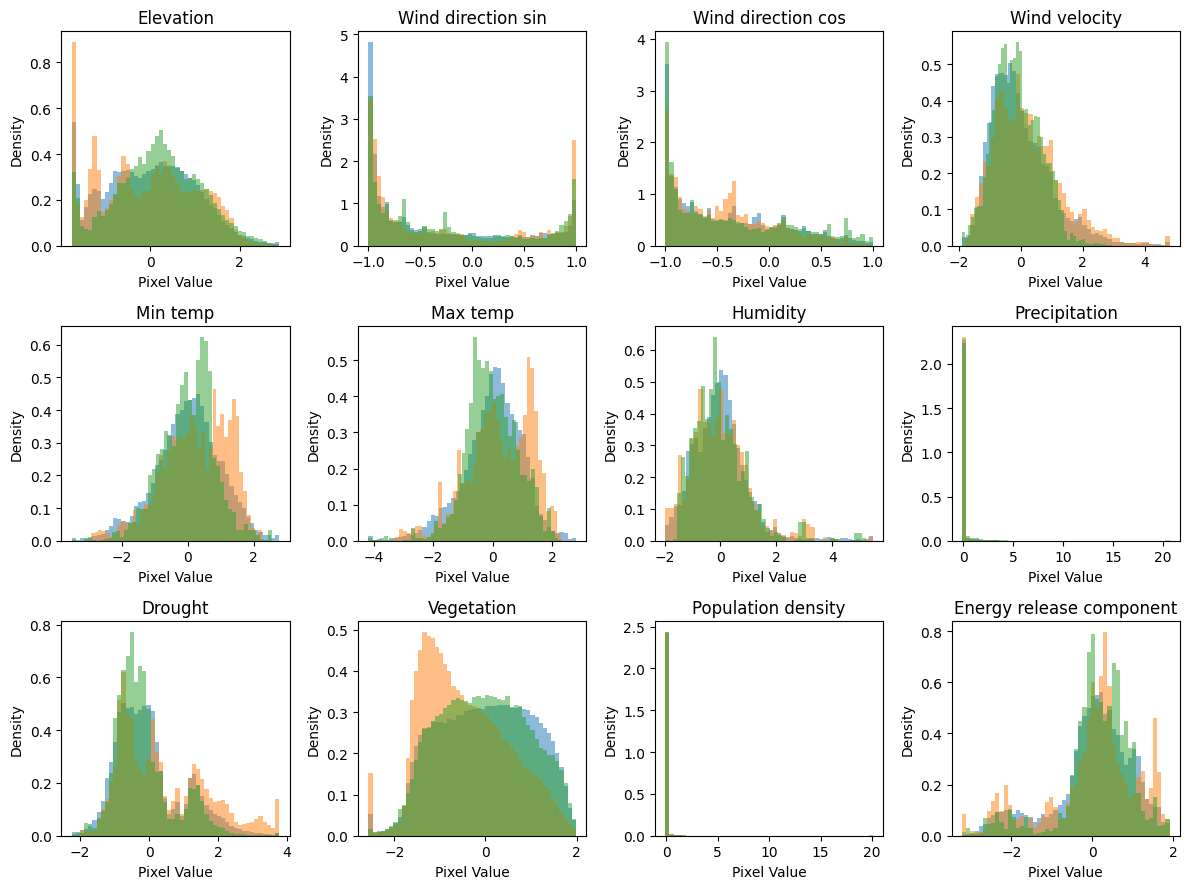

In [ ]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

variables = [  'Elevation',
  'Wind direction sin',
  'Wind direction cos',
  'Wind velocity',
  'Min temp',
  'Max temp',
  'Humidity',
  'Precipitation',
  'Drought',
  'Vegetation',
  'Population density',
  'Energy release component',
  'Previous fire mask']
  #'Fire mask']


def plot_distributions_split(train_features, val_features, test_features):
  # features should have 13 channels. Prev Fire Mask is not plot
  assert train_features.shape[-1] == val_features.shape[-1] == test_features.shape[-1], "All input datasets must have the same number of features"
  num_channels = train_features.shape[-1]
  num_features = len(variables)
  fig, axs = plt.subplots(3, 4, figsize=(12, 9))
  axs = axs.flatten()
  for feature in range(num_features):
      if feature == 12:
        continue
      if feature > 12:
        ax = axs[feature-1]
      else:
        ax = axs[feature]

      train_data = train_features[..., feature].flatten()
      val_data = val_features[..., feature].flatten()
      test_data = test_features[..., feature].flatten()
      ax.hist(train_data, bins=50, density=True, alpha=0.5, label=f'Train (mean: {np.mean(train_data):.2f}, std: {np.std(train_data):.2f})')
      ax.hist(val_data, bins=50, density=True, alpha=0.5, label=f'Val (mean: {np.mean(val_data):.2f}, std: {np.std(val_data):.2f})')
      ax.hist(test_data, bins=50, density=True, alpha=0.5, label=f'Test (mean: {np.mean(test_data):.2f}, std: {np.std(test_data):.2f})')
      ax.set_title(variables[feature])
      ax.set_xlabel("Pixel Value")
      ax.set_ylabel("Density")

  plt.tight_layout()
  plt.show()

plot_distributions_split(train_features, val_features, test_features)

# Dummy Model: Predict the same fire mask as previous-day

In [ ]:
(num_samples, r, r, num_features) = test_features.shape

# Predict the previous-day fire mask on test set
dummy_predictions = np.zeros(shape=(num_samples,r,r,1))
for i in range(num_samples):
  dummy_predictions[i,:,:,:] = test_features[i,:,:,12:]

In [ ]:
# Compute AUC of dummy model
from sklearn.metrics import roc_auc_score

# Flatten the arrays
y_true_flat = test_labels.ravel()
y_scores_flat = dummy_predictions.ravel()

# Compute the AUC
auc = roc_auc_score(y_true_flat, y_scores_flat)
print("AUC:", auc)

AUC: 0.6755995119833365


# Predict next day fire masks

### Benchmark: linear regression & logistic regression

In [ ]:
def flatten(final_certain_input_array, final_certain_labels):
  """ Returns flat inputs and flat labels for linear models"""
  flat_features = []
  flat_labels = []
  for var in range(final_certain_input_array.shape[2]):
    flat_feature = []
    for obs in range(final_certain_input_array.shape[3]):
      for row in range(final_certain_input_array.shape[0]):
          for col in range(final_certain_input_array.shape[1]):
              flat_feature.append(final_certain_input_array[row, col, var, obs])
    flat_features.append(np.array(flat_feature))

  for obs in range(final_certain_labels.shape[2]):
    for row in range(final_certain_labels.shape[0]):
        for col in range(final_certain_labels.shape[1]):
            flat_labels.append(final_certain_labels[row, col, obs])
  flat_labels = np.array(flat_labels)
  return flat_features, flat_labels

In [ ]:
flat_features, flat_labels = flatten(final_certain_input_array, final_certain_labels)
val_flat_features, val_flat_labels = flatten(val_final_certain_input_array, val_final_certain_labels)
test_flat_features, test_flat_labels = flatten(test_final_certain_input_array, test_final_certain_labels)

In [ ]:
X_train = np.vstack([np.transpose(feature) for feature in flat_features])
X_train = np.transpose(X_train) #so that observations correspond to rows now
Y_train = flat_labels

X_val = np.vstack([np.transpose(feature) for feature in val_flat_features])
X_val = np.transpose(X_val)
Y_val = val_flat_labels

X_test = np.vstack([np.transpose(feature) for feature in test_flat_features])
X_test = np.transpose(X_test)
Y_test = test_flat_labels

In [ ]:
# standardize because the units are NOT the same for the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [ ]:
#Benchmark method: Try linear regression

variables = [  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask']

#Regression time!
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

lr_fire = LinearRegression().fit(X_train_scaled, Y_train)

print('training R2-score:', np.round(   r2_score(  Y_train, lr_fire.predict(X_train_scaled)),2  )   )

scores_fire = cross_val_score(lr_fire, X_train_scaled, Y_train, cv=10, scoring='r2')

print("validation R2-scores:",np.round(scores_fire,2))
print("average:", np.round(np.mean(scores_fire),2))

print('LR coefficients:')
for i, coeff in enumerate(lr_fire.coef_):
    print('{0:5s}  {1:>-10.2f}'.format(variables[i], np.round(coeff,2)))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, Y_train)

# Prediction and Evaluation
Y_pred = log_reg.predict(X_train_scaled)
print('Training accuracy:', accuracy_score(Y_train, Y_pred))
print('Classification report:\n', classification_report(Y_train, Y_pred))

# Cross-validation
scores_accuracy = cross_val_score(log_reg, X_train_scaled, Y_train, cv=10, scoring='accuracy')
print("Validation accuracy scores:", np.round(scores_accuracy, 2))
print("Average accuracy:", np.round(np.mean(scores_accuracy), 2))

print('Logistic Regression coefficients:')
for i, coeff in enumerate(log_reg.coef_[0]):
    print('{0:30s} {1:>-10.2f}'.format(variables[i], coeff))


### CNN: Weighted cross-entropy loss
Different weights on the ‘fire’ labels to take into account
the class imbalance

In [ ]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(13, 16, kernel_size=3, padding='same')
        self.pool = nn.MaxPool2d(2, padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv_new = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2, padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2, padding='same')
        #self.bn4 = nn.BatchNorm2d(128)

        # Decoder
        self.t_conv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.t_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 1, kernel_size=1, padding='same')

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv_new(x)))
        #x = self.pool(x)
        x = F.relu(self.bn3(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        # Decoder
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        #x = torch.sigmoid(self.conv4(x))
        x = self.conv4(x)  # Output logits for BCEWithLogitsLoss

        return x

In [ ]:
def train_model(model, data_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            # print("Output shape:", outputs.shape)
            # print("Target shape:", targets.shape)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(data_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


In [ ]:
def train_model_physics(model, data_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            # print("Output shape:", outputs.shape)
            # print("Target shape:", targets.shape)
            loss = criterion(outputs, targets, inputs[:,-1:,:,:])
            #print(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(data_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


In [ ]:
class FirePhysicsInducedLoss(nn.Module):
    def __init__(self, alpha):
        super(FirePhysicsInducedLoss, self).__init__()
        self.bce_with_logits = nn.BCEWithLogitsLoss()
        self.alpha = alpha

    def forward(self, output, target, prev_fire_mask):
        bce_loss = self.bce_with_logits(output, target)
        probabilities = torch.sigmoid(output)
        mask = (prev_fire_mask != 1).float()
        penalty = -torch.mean(mask * probabilities) #+ torch.mean(prev_fire_mask * probabilities)
        loss = bce_loss + self.alpha * penalty
        return loss

In [ ]:
# Create dataset
train_features_tensor = torch.tensor(train_features, dtype=torch.float32).permute(0, 3, 1, 2) # [batch_size, channels, height, width]
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).permute(0, 3, 1, 2)

train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=False)

val_features_tensor = torch.tensor(val_features, dtype=torch.float32).permute(0, 3, 1, 2) # [batch_size, channels, height, width]
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32).permute(0, 3, 1, 2)

val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)

test_features_tensor = torch.tensor(test_features, dtype=torch.float32).permute(0, 3, 1, 2) # [batch_size, channels, height, width]
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).permute(0, 3, 1, 2)

test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Final Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN = CNN_model().to(device)

optimizer = torch.optim.Adam(CNN.parameters(), lr=0.001)

criterion = FirePhysicsInducedLoss(alpha=0.1)

num_epochs = 10
train_model_physics(CNN, train_loader, criterion, optimizer, device, num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/10, Loss: 0.0109
Epoch 2/10, Loss: 0.0089
Epoch 3/10, Loss: 0.0087
Epoch 4/10, Loss: 0.0086
Epoch 5/10, Loss: 0.0085
Epoch 6/10, Loss: 0.0084
Epoch 7/10, Loss: 0.0083
Epoch 8/10, Loss: 0.0083
Epoch 9/10, Loss: 0.0082
Epoch 10/10, Loss: 0.0081


In [ ]:
  !pip install torchmetrics
  import torch
  import torchmetrics
  from torchmetrics import AUROC

In [ ]:
CNN.eval()

auc_metric = torchmetrics.AUROC(task="binary")

predictions = []
actual_labels = []
# total = 0
# correct = 0

with torch.no_grad():
    for i, l in test_loader:
        i, l = i.to(device), l.to(device)
        # print(i.shape, l.shape)
        outputs = CNN(i)

        predicted_probs = torch.sigmoid(outputs) # sigmoid to convert logits to probabilities
        predictions.extend(predicted_probs.cpu())
        actual_labels.extend(l.cpu())
        # total += l.numel()
        auc_metric.update(predicted_probs, l)
        # correct += ((predicted_probs > 0.5)== l).sum().item()
auc_score = auc_metric.compute()

print(f'The AUC score is: {auc_score:.4f}')
# print(f"Accuracy: {100 * correct / total}%")
# Concatenate all batches into a single tensor
predictions = torch.cat(predictions, dim=0)
actual_labels = torch.cat(actual_labels, dim=0)

The AUC score is: 0.8841


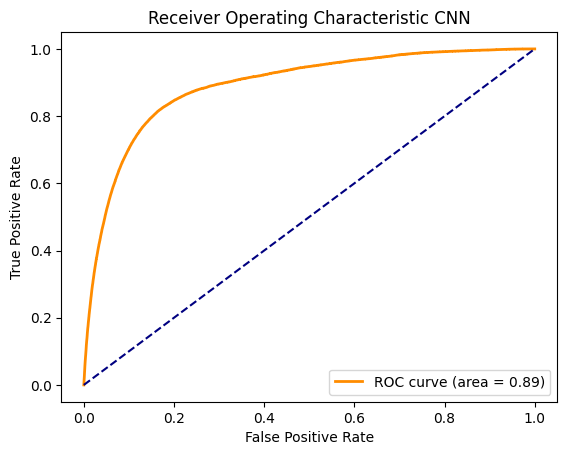

In [ ]:
import torchmetrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Flatten the tensors from [472, 32, 32] to [472*32*32]
predicted_probs_flat = predictions.view(-1)  # Flatten predicted probabilities
true_labels_flat = actual_labels.view(-1)  # Flatten true labels
predicted_probs_np = predicted_probs_flat.cpu().numpy()
true_labels_np = true_labels_flat.cpu().numpy()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels_np, predicted_probs_np)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic CNN')
plt.legend(loc="lower right")
plt.show()


IndexError: index 4 is out of bounds for axis 0 with size 4

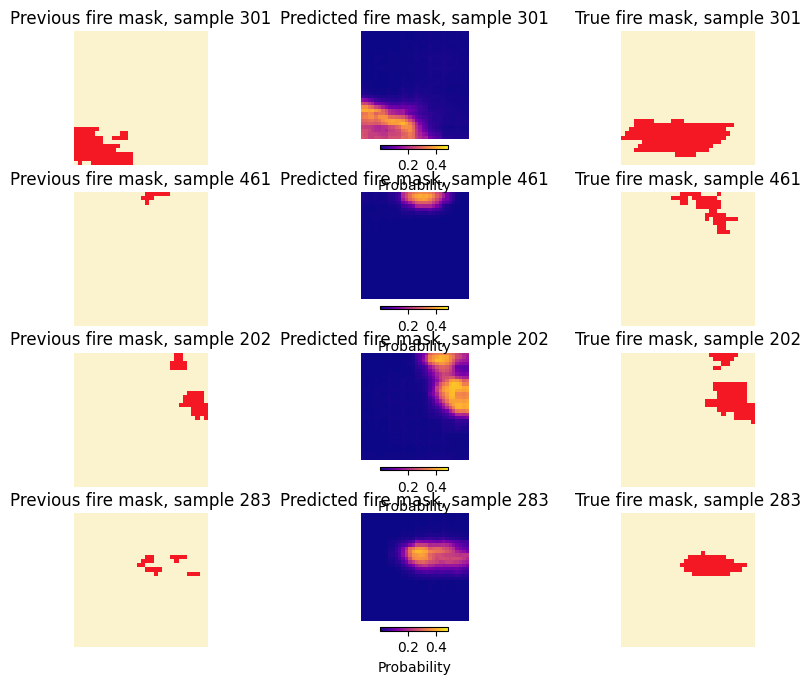

In [ ]:
# Get best and worse predictions
lit_pixels = np.count_nonzero(test_labels, axis=(1, 2)).squeeze()
errors = torch.mean(np.abs(predictions - test_labels.squeeze()), axis=(1, 2)) / (lit_pixels + 1e-8) # compute mean by fire
N=4
best_indices = np.argsort(errors)[N:]

fig, axes = plt.subplots(nrows=N, ncols=3, figsize=(10, 2 * N))

CMAP = colors.ListedColormap(['black', "#FAF3CE", '#F41724'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
vmin = predictions.min().item()
vmax = predictions.max().item()

for idx, sample_index in enumerate(best_indices):
    ax = axes[idx, 0]
    ax.imshow(test_features[sample_index,:,:,-1].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Previous fire mask, sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 1]
    #ax.imshow(preds_test[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    probabilities_np = predictions[sample_index].numpy()
    im = ax.imshow(probabilities_np, cmap='plasma', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(f'Predicted fire mask, sample {sample_index}')
    ax.axis('off')
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.3, pad=0.05)
    cbar.set_label('Probability')

    ax = axes[idx, 2]
    ax.imshow(test_labels[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'True fire mask, sample {sample_index}')
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Choose hyperparameters

In [ ]:
auc_dict = dict()

for lr in [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  CNN = CNN_model().to(device)

  optimizer = torch.optim.Adam(CNN.parameters(), lr=lr)
  criterion = nn.BCEWithLogitsLoss()

  num_epochs = 20
  train_model(CNN, train_loader, criterion, optimizer, device, num_epochs)
  CNN.eval()

  auc_metric = torchmetrics.AUROC(task="binary")

  predictions = []
  actuals = []

  with torch.no_grad():
      for i, l in val_loader:
          i, l = i.to(device), l.to(device)
          outputs = CNN(i)
          # Apply sigmoid to convert logits to probabilities
          predicted_probs = torch.sigmoid(outputs)
          predictions.extend(predicted_probs)
          actuals.extend(l)
          auc_metric.update(predicted_probs, l)
  auc_score = auc_metric.compute()

  print(f'lr = {lr}, The AUC score is: {auc_score:.4f}')
  auc_dict[lr] = auc_score


Epoch 1/20, Loss: 0.1004
Epoch 2/20, Loss: 0.1004
Epoch 3/20, Loss: 0.1004
Epoch 4/20, Loss: 0.1004
Epoch 5/20, Loss: 0.1004
Epoch 6/20, Loss: 0.1004
Epoch 7/20, Loss: 0.1004
Epoch 8/20, Loss: 0.1004
Epoch 9/20, Loss: 0.1004
Epoch 10/20, Loss: 0.1004
Epoch 11/20, Loss: 0.1004
Epoch 12/20, Loss: 0.1004
Epoch 13/20, Loss: 0.1004
Epoch 14/20, Loss: 0.1004
Epoch 15/20, Loss: 0.1004
Epoch 16/20, Loss: 0.1004
Epoch 17/20, Loss: 0.1004
Epoch 18/20, Loss: 0.1004
Epoch 19/20, Loss: 0.1004
Epoch 20/20, Loss: 0.1004
lr = 0, The AUC score is: 0.4971
Epoch 1/20, Loss: 0.0145
Epoch 2/20, Loss: 0.0126
Epoch 3/20, Loss: 0.0124
Epoch 4/20, Loss: 0.0123
Epoch 5/20, Loss: 0.0123
Epoch 6/20, Loss: 0.0122
Epoch 7/20, Loss: 0.0121
Epoch 8/20, Loss: 0.0121
Epoch 9/20, Loss: 0.0120
Epoch 10/20, Loss: 0.0119
Epoch 11/20, Loss: 0.0119
Epoch 12/20, Loss: 0.0118
Epoch 13/20, Loss: 0.0118
Epoch 14/20, Loss: 0.0117
Epoch 15/20, Loss: 0.0116
Epoch 16/20, Loss: 0.0116
Epoch 17/20, Loss: 0.0115
Epoch 18/20, Loss: 0.01

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

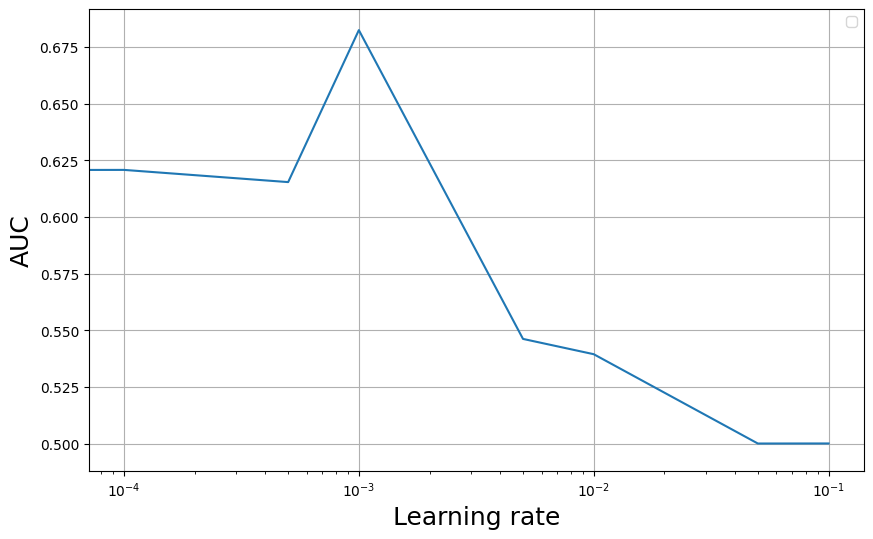

In [ ]:
for lr, auc_score in auc_dict.items():
    auc_dict[lr] = auc_score.cpu().numpy()
from google.colab import files

fig = plt.figure(figsize=(10, 6))
plt.plot(list(auc_dict.keys()), list(auc_dict.values()))
#plt.title('AUC vs Learning Rate')
plt.xlabel('Learning rate', fontsize = 18)
plt.ylabel('AUC', fontsize = 18)
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.savefig("auc_vs_lr.png",dpi=200,bbox_inches="tight")
files.download("auc_vs_lr.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

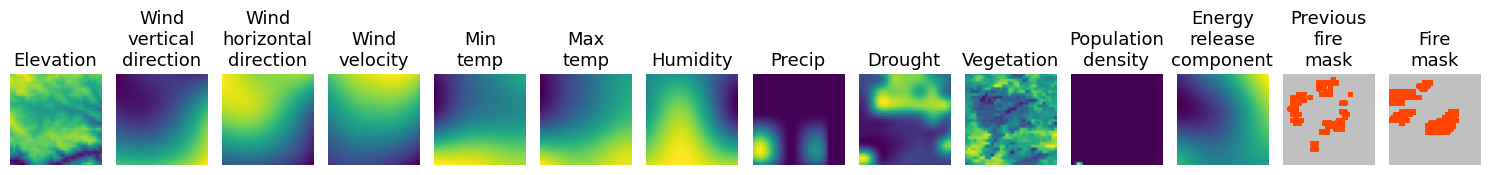

In [ ]:
TITLES = [
  'Elevation',
  'Wind\nvertical\ndirection',
  'Wind\nhorizontal\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

# Number of rows of data samples to plot
n_rows = 1
# Number of data variables
n_features = features.shape[3]

# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(features[i+4, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(features[i+4, :, :, -1], cmap=CMAP, norm=NORM)
    if j == n_features:
      plt.imshow(labels[i+4, :, :, 0], cmap=CMAP, norm=NORM)
    plt.axis('off')
plt.savefig("viz.png",dpi=200,bbox_inches="tight")
files.download("viz.png")
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

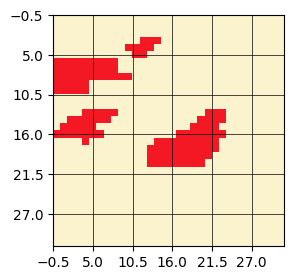

In [ ]:
from google.colab import files
CMAP = colors.ListedColormap(['black', "#FAF3CE", '#F41724'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

plt.figure(figsize=(3,3))
plt.imshow(train_labels[5, :, :, 0], cmap=CMAP, norm=NORM)
plt.grid(which='both', color='black', linestyle='-', linewidth=0.5)
plt.xticks(np.arange(-0.5, train_labels.shape[2], 5.5))  # Setting tick marks for grid lines
plt.yticks(np.arange(-0.5, train_labels.shape[1], 5.5))
# plt.xticks(range(-.5,labels.shape[2]), minor=True)  # Setting tick marks for grid lines
# plt.yticks(range(-.5,labels.shape[1]), minor=True)
plt.savefig("mask.png",dpi=100,bbox_inches="tight")
files.download("mask.png")
plt.show()

In [ ]:
v = list(auc_dict.values())

lr = list(auc_dict.keys())[v.index(max(v))]
lr

0.001

In [ ]:
weights_dict = dict()

for weight in [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0]:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  CNN = CNN_model().to(device)

  optimizer = torch.optim.Adam(CNN.parameters(), lr=0.001)

  pos_weight = torch.FloatTensor([weight]).to(device)
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  num_epochs = 18
  train_model(CNN, train_loader, criterion, optimizer, device, num_epochs)
  CNN.eval()

  auc_metric = torchmetrics.AUROC(task="binary")

  predictions = []
  actuals = []

  with torch.no_grad():
      for i, l in val_loader:
          i, l = i.to(device), l.to(device)
          outputs = CNN(i)
          # Apply sigmoid to convert logits to probabilities
          predicted_probs = torch.sigmoid(outputs)
          predictions.extend(predicted_probs)
          actuals.extend(l)
          auc_metric.update(predicted_probs, l)
  auc_score = auc_metric.compute()

  print(f'pos-weights = {weight}, The AUC score is: {auc_score:.4f}')
  weights_dict[weight] = auc_score


Epoch 1/18, Loss: 0.0136
Epoch 2/18, Loss: 0.0125
Epoch 3/18, Loss: 0.0123
Epoch 4/18, Loss: 0.0122
Epoch 5/18, Loss: 0.0122
Epoch 6/18, Loss: 0.0121
Epoch 7/18, Loss: 0.0120
Epoch 8/18, Loss: 0.0119
Epoch 9/18, Loss: 0.0118
Epoch 10/18, Loss: 0.0117
Epoch 11/18, Loss: 0.0116
Epoch 12/18, Loss: 0.0115
Epoch 13/18, Loss: 0.0115
Epoch 14/18, Loss: 0.0113
Epoch 15/18, Loss: 0.0112
Epoch 16/18, Loss: 0.0111
Epoch 17/18, Loss: 0.0108
Epoch 18/18, Loss: 0.0105
pos-weights = 1.0, The AUC score is: 0.6591
Epoch 1/18, Loss: 0.0285
Epoch 2/18, Loss: 0.0271
Epoch 3/18, Loss: 0.0268
Epoch 4/18, Loss: 0.0265
Epoch 5/18, Loss: 0.0264
Epoch 6/18, Loss: 0.0263
Epoch 7/18, Loss: 0.0261
Epoch 8/18, Loss: 0.0260
Epoch 9/18, Loss: 0.0257
Epoch 10/18, Loss: 0.0255
Epoch 11/18, Loss: 0.0254
Epoch 12/18, Loss: 0.0251
Epoch 13/18, Loss: 0.0247
Epoch 14/18, Loss: 0.0246
Epoch 15/18, Loss: 0.0243
Epoch 16/18, Loss: 0.0239
Epoch 17/18, Loss: 0.0235
Epoch 18/18, Loss: 0.0232
pos-weights = 3.0, The AUC score is: 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

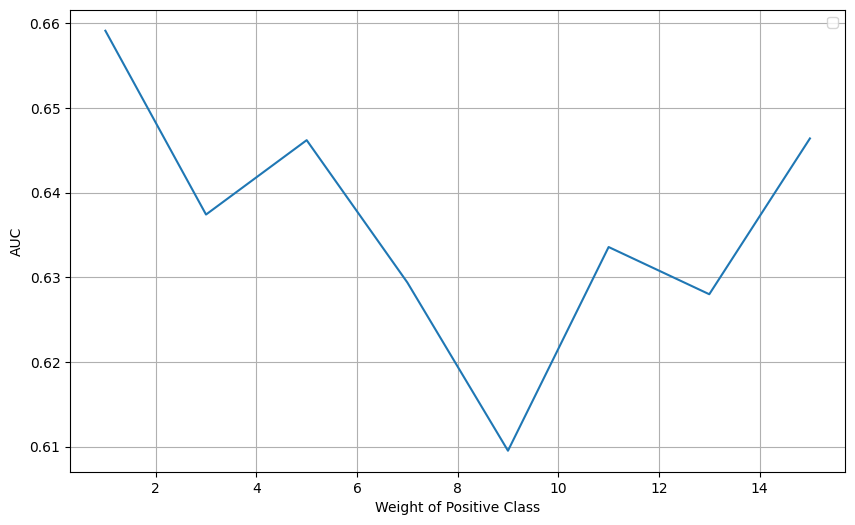

In [ ]:
for w, auc_score in weights_dict.items():
    weights_dict[w] = auc_score.cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot([1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0], list(weights_dict.values()))
#plt.title('AUC vs Weight of Positive Class')
plt.xlabel('Weight of Positive Class')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.savefig("auc_vs_weights.png",dpi=200,bbox_inches="tight")
files.download("auc_vs_weights.png")
plt.show()

#### Final CNN

In [ ]:
# Final Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN = CNN_model().to(device)

optimizer = torch.optim.Adam(CNN.parameters(), lr=0.001)

pos_weight = torch.FloatTensor([1.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

num_epochs = 20
train_model(CNN, train_loader, criterion, optimizer, device, num_epochs)

Epoch 1/20, Loss: 0.0121
Epoch 2/20, Loss: 0.0090
Epoch 3/20, Loss: 0.0087
Epoch 4/20, Loss: 0.0086
Epoch 5/20, Loss: 0.0085
Epoch 6/20, Loss: 0.0084
Epoch 7/20, Loss: 0.0083
Epoch 8/20, Loss: 0.0082
Epoch 9/20, Loss: 0.0081
Epoch 10/20, Loss: 0.0080
Epoch 11/20, Loss: 0.0078
Epoch 12/20, Loss: 0.0077
Epoch 13/20, Loss: 0.0076
Epoch 14/20, Loss: 0.0074
Epoch 15/20, Loss: 0.0073
Epoch 16/20, Loss: 0.0072
Epoch 17/20, Loss: 0.0071
Epoch 18/20, Loss: 0.0069
Epoch 19/20, Loss: 0.0068
Epoch 20/20, Loss: 0.0066


In [ ]:
CNN.eval()

auc_metric = torchmetrics.AUROC(task="binary")

predictions = []
actual_labels = []
# total = 0
# correct = 0

with torch.no_grad():
    for i, l in test_loader:
        i, l = i.to(device), l.to(device)
        # print(i.shape, l.shape)
        outputs = CNN(i)

        predicted_probs = torch.sigmoid(outputs) # sigmoid to convert logits to probabilities
        predictions.extend(predicted_probs.cpu())
        actual_labels.extend(l.cpu())
        # total += l.numel()
        auc_metric.update(predicted_probs, l)
        # correct += ((predicted_probs > 0.5)== l).sum().item()
auc_score = auc_metric.compute()

print(f'The AUC score is: {auc_score:.4f}')
# print(f"Accuracy: {100 * correct / total}%")
# Concatenate all batches into a single tensor
predictions = torch.cat(predictions, dim=0)
actual_labels = torch.cat(actual_labels, dim=0)

The AUC score is: 0.8763


In [ ]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# # Save the tensor to a file in the 'my_dir' directory on Google Drive
# torch.save(predictions, "/content/drive/My Drive/Computer Vision/Project/Predictions/predictions_CNN")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


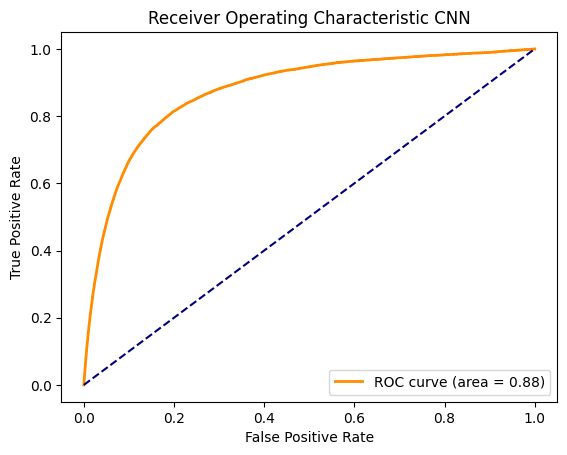

In [ ]:
import torchmetrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Flatten the tensors from [472, 32, 32] to [472*32*32]
predicted_probs_flat = predictions.view(-1)  # Flatten predicted probabilities
true_labels_flat = actual_labels.view(-1)  # Flatten true labels
predicted_probs_np = predicted_probs_flat.cpu().numpy()
true_labels_np = true_labels_flat.cpu().numpy()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels_np, predicted_probs_np)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic CNN')
plt.legend(loc="lower right")
plt.show()


In [ ]:
preds_test = predictions > 0.3

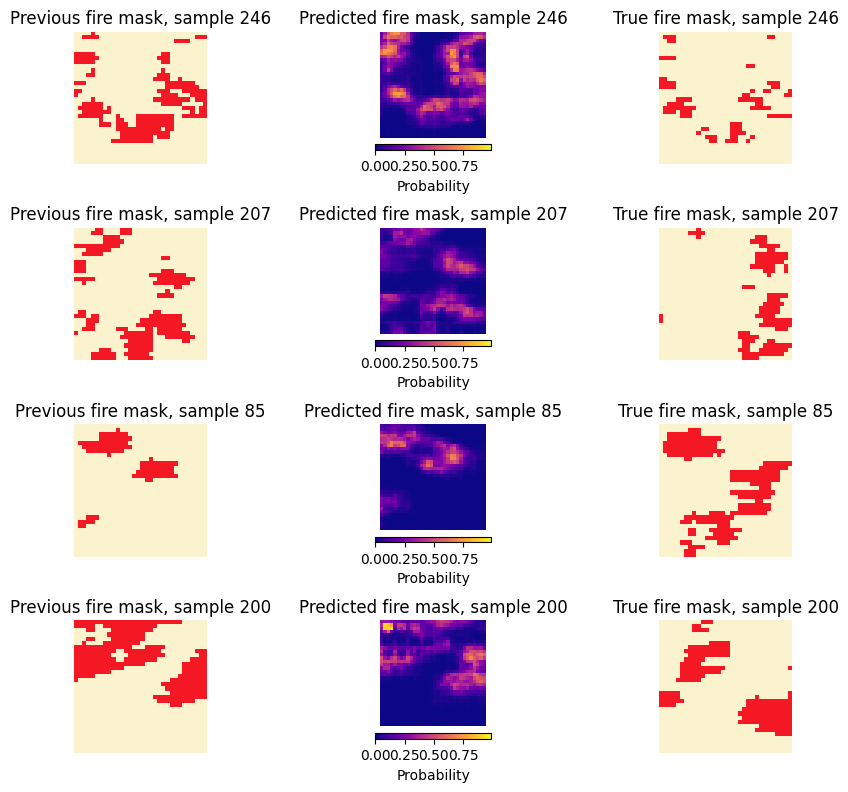

In [ ]:
# Get best and worse predictions
lit_pixels = np.count_nonzero(test_labels, axis=(1, 2)).squeeze()
errors = torch.mean(np.abs(predictions - test_labels.squeeze()), axis=(1, 2)) / (lit_pixels + 1e-8) # compute mean by fire
N=4
best_indices = np.argsort(errors)[:N]

fig, axes = plt.subplots(nrows=N, ncols=3, figsize=(10, 2 * N))

CMAP = colors.ListedColormap(['black', "#FAF3CE", '#F41724'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
vmin = predictions.min().item()
vmax = predictions.max().item()

for idx, sample_index in enumerate(best_indices):
    ax = axes[idx, 0]
    ax.imshow(test_features[sample_index,:,:,-1].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Previous fire mask, sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 1]
    #ax.imshow(preds_test[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    probabilities_np = predictions[sample_index].numpy()
    im = ax.imshow(probabilities_np, cmap='plasma', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(f'Predicted fire mask, sample {sample_index}')
    ax.axis('off')
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.3, pad=0.05)
    cbar.set_label('Probability')

    ax = axes[idx, 2]
    ax.imshow(test_labels[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'True fire mask, sample {sample_index}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Indices of worst predicted samples: tensor([340, 360,  85, 207, 200])
Errors: tensor([0.2324, 0.2334, 0.2637, 0.2676, 0.2900])


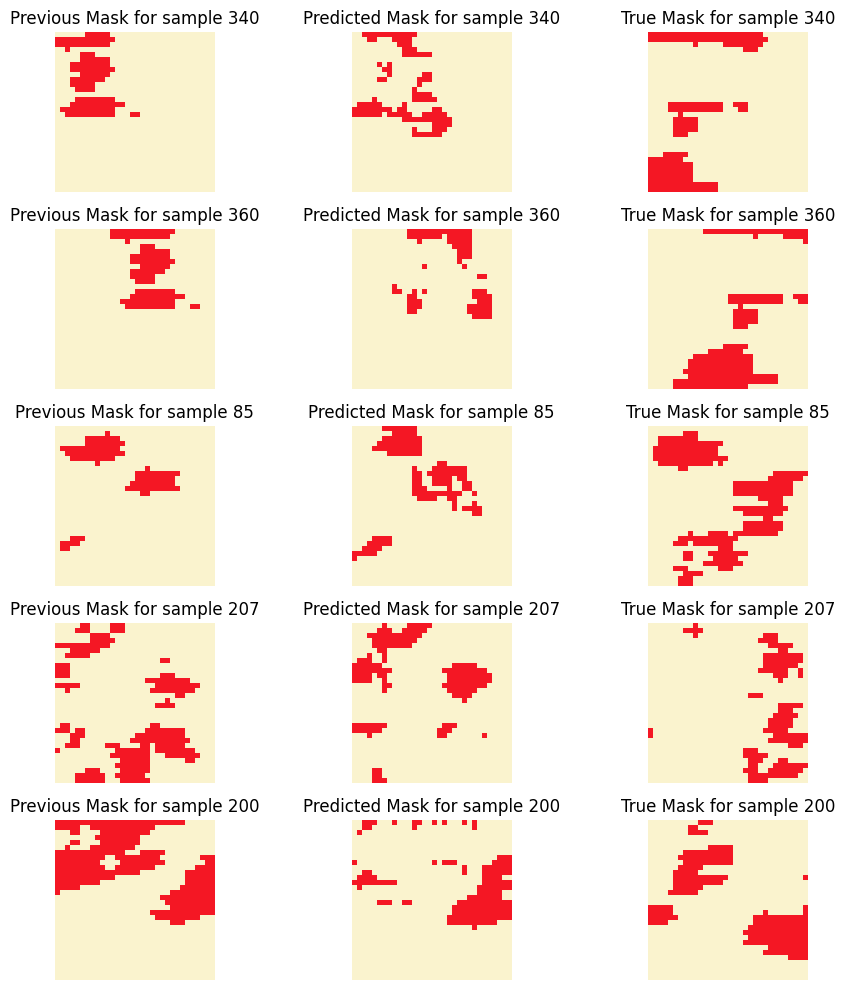

In [ ]:
# Worst predictions
worst_indices = np.argsort(errors)[-N:]

worst_errors = errors[worst_indices]
print("Indices of worst predicted samples:", worst_indices)
print("Errors:", worst_errors)

fig, axes = plt.subplots(nrows=N, ncols=3, figsize=(10, 2 * N))

CMAP = colors.ListedColormap(['black', "#FAF3CE", '#F41724'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
for idx, sample_index in enumerate(worst_indices):
    ax = axes[idx, 0]
    ax.imshow(test_features[sample_index,:,:,-1].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Previous Mask for sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 1]
    ax.imshow(preds_test[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Predicted Mask for sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 2]
    ax.imshow(test_labels[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'True Mask for sample {sample_index}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### PINN

In [ ]:
import torch
import torch.nn.functional as F

def custom_loss(y_true, y_pred, temp_min, temp_max, eps=1, T_min_ignition=150, T_max_ignition=300):
    bce_loss = nn.binary_cross_entropy_with_logits(y_pred, y_true)

    # Calculate penalty for predicting fire below the temperature threshold
    mask = (temp_min < T_min_ignition) | (temp_max > T_max_ignition)
    penalty = (y_pred.sigmoid() > 0.5) & mask # pixels lit where they shouldn't be
    penalty = penalty.float().mean()  # Average penalty per batch

    return bce_loss + eps * penalty


In [ ]:
def train_model_pinn(model, data_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            temp_min = inputs[:, 4, :, :]
            temp_max = inputs[:, 5, :, :]
            rest_inputs = inputs[:, :4, :, :]

            outputs = model(rest_inputs)
            # print("Output shape:", outputs.shape)
            # print("Target shape:", targets.shape)
            loss = custom_loss(targets, outputs, temp_min, temp_max)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(data_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


In [ ]:
# Final Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PINN = CNN_model().to(device)

optimizer = torch.optim.Adam(PINN.parameters(), lr=0.001)

#pos_weight = torch.FloatTensor([5.0]).to(device)
#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 20
train_model_pinn(PINN, train_loader, criterion, optimizer, device, num_epochs)

In [ ]:
PINN.eval()

auc_metric = torchmetrics.AUROC(task="binary")

predictions = []
actual_labels = []
total = 0
correct = 0

with torch.no_grad():
    for i, l in test_loader:
        i, l = i.to(device), l.to(device)
        # print(i.shape, l.shape)
        outputs = PINN(i)

        predicted_probs = torch.sigmoid(outputs) # sigmoid to convert logits to probabilities
        predictions.extend(predicted_probs.cpu())
        actual_labels.extend(l.cpu())
        total += l.numel()
        auc_metric.update(predicted_probs, l)
        correct += ((predicted_probs > 0.5)== l).sum().item()
auc_score = auc_metric.compute()

print(f'The AUC score is: {auc_score:.4f}')
print(f"Accuracy: {100 * correct / total}%")
# Concatenate all batches into a single tensor
predictions = torch.cat(predictions, dim=0)
actual_labels = torch.cat(actual_labels, dim=0)

In [ ]:
preds_test = predictions > 0.5
correct = preds_test == actual_labels  # Assuming binary classification
accuracy = correct.float().mean()  # Mean of correct predictions
print(f"Accuracy: {accuracy.item() * 100:.2f}%")


### U-Net architecture

#### Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

def conv_block(input_tensor, num_filters):
    """Function to add two convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = Dropout(0.1)(x)
    # second layer
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    return x

def encoder_block(input_tensor, num_filters):
    """Function to add two convolutional blocks and then perform max pooling and dropout"""
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    """Function to perform upsampling, concatenate skipped connection and two convolutional blocks"""
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = concatenate([x, concat_tensor], axis=-1)
    x = Dropout(0.1)(x)
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    """Function to build U-Net"""
    inputs = Input(input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
# Build U-Net model
unet_model = build_unet((32, 32, 12))
unet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

In [ ]:
unet_history = unet_model.fit(features, labels, epochs=20, batch_size=16, validation_data=(val_features, val_labels))

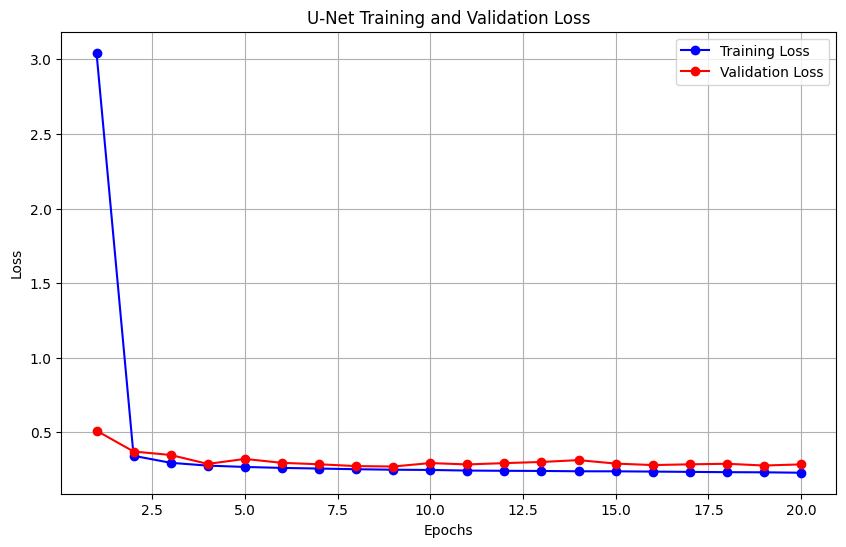

In [ ]:
import matplotlib.pyplot as plt
loss = unet_history.history['loss']
val_loss = unet_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
plt.plot(epochs, loss, label='Training Loss', color='blue', marker='o')
if val_loss is not None:
    plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')

plt.title('U-Net Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Optional: Adds a grid for easier reading
plt.show()

In [ ]:
# model_save_path = '/content/drive/My Drive/Colab Notebooks/my_unet_model.h5'
# # Save model
# unet_model.save(model_save_path)

In [ ]:
# Evaluate on test set
unet_scores = unet_model.evaluate(test_features, test_labels)
print(f'Test Loss: {unet_scores[0]}, Test Accuracy: {unet_scores[1]}, Test AUC: {unet_scores[2]}')

11/11 [==============================] - 3s 110ms/step - loss: 0.2549 - accuracy: 0.9389 - auc: 0.6442
Test Loss: 0.2548823058605194, Test Accuracy: 0.93889981508255, Test AUC: 0.6441639065742493


In [ ]:
# Predictions sur X_train
unet_predicted_masks = unet_model.predict(test_features[:20,:,:,:])

1/1 [==============================] - 2s 2s/step


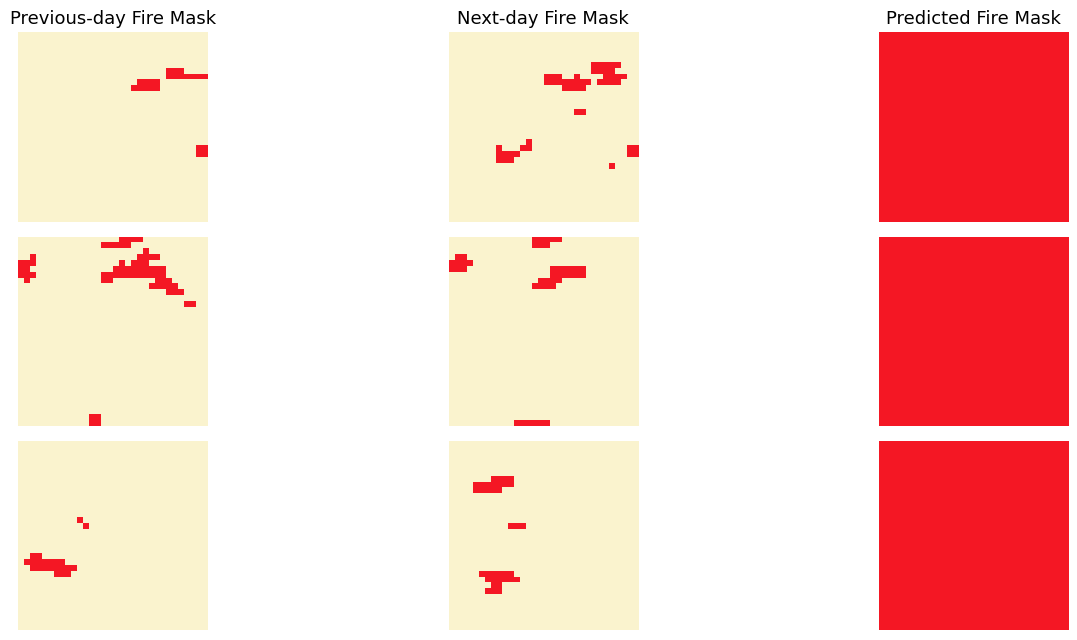

In [ ]:
TITLES_pred = ["Previous-day Fire Mask", "Next-day Fire Mask","Predicted Fire Mask"]
fig = plt.figure(figsize=(15,6.5))
n_rows = 3
n_features = 2
CMAP = colors.ListedColormap(['black', "#FAF3CE", '#F41724'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features+1, i * (n_features+1) + j + 1)
    if i == 0:
      plt.title(TITLES_pred[j], fontsize=13)
    if j == 0:
      plt.imshow(test_features[i, :, :, 11], cmap=CMAP, norm=NORM)
    if j == 1:
      plt.imshow(test_labels[i, :, :, 0], cmap=CMAP, norm=NORM)
    if j == 2:
      plt.imshow(unet_predicted_masks[i,:,:], cmap=CMAP, norm=NORM)
    plt.axis('off')
plt.tight_layout()

#### Torch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, middle_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(middle_channels + out_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv_block(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = EncoderBlock(13, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)

        self.bottleneck = ConvBlock(512, 1024)

        self.decoder1 = DecoderBlock(1024, 512, 512)
        self.decoder2 = DecoderBlock(512, 256, 256)
        self.decoder3 = DecoderBlock(256, 128, 128)
        self.decoder4 = DecoderBlock(128, 64, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        c1, p1 = self.encoder1(x)
        c2, p2 = self.encoder2(p1)
        c3, p3 = self.encoder3(p2)
        c4, p4 = self.encoder4(p3)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        d1 = self.decoder1(b, c4)
        d2 = self.decoder2(d1, c3)
        d3 = self.decoder3(d2, c2)
        d4 = self.decoder4(d3, c1)

        # Output
        output = self.final_conv(d4)
        return output

In [ ]:
# Create dataset
train_features_tensor = torch.tensor(train_features, dtype=torch.float32).permute(0, 3, 1, 2) # [batch_size, channels, height, width]
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).permute(0, 3, 1, 2)

train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=False)

val_features_tensor = torch.tensor(val_features, dtype=torch.float32).permute(0, 3, 1, 2) # [batch_size, channels, height, width]
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32).permute(0, 3, 1, 2)

val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)

test_features_tensor = torch.tensor(test_features, dtype=torch.float32).permute(0, 3, 1, 2) # [batch_size, channels, height, width]
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).permute(0, 3, 1, 2)

test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
UNET = UNet().to(device)
#print(UNET)

optimizer = torch.optim.Adam(UNET.parameters(), lr=0.001)

#pos_weight = torch.FloatTensor([3.0]).to(device)
#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 10
train_model(UNET, train_loader, criterion, optimizer, device, num_epochs)

Epoch 1/10, Loss: 0.0128
Epoch 2/10, Loss: 0.0094
Epoch 3/10, Loss: 0.0091
Epoch 4/10, Loss: 0.0087
Epoch 5/10, Loss: 0.0085
Epoch 6/10, Loss: 0.0084
Epoch 7/10, Loss: 0.0083
Epoch 8/10, Loss: 0.0082
Epoch 9/10, Loss: 0.0081
Epoch 10/10, Loss: 0.0081


In [ ]:
UNET.eval()
# !pip install torchmetrics
import torch
import torchmetrics
auc_metric = torchmetrics.AUROC(task="binary")

predictions = []
actuals = []

with torch.no_grad():
    for i, l in test_loader:
        i, l = i.to(device), l.to(device)
        outputs = UNET(i)
        predicted_probs = torch.sigmoid(outputs)
        predictions.extend(predicted_probs.cpu())
        actuals.extend(l)
        auc_metric.update(predicted_probs, l)

auc_score = auc_metric.compute()
predictions = torch.cat(predictions, dim=0).unsqueeze(-1)
print(f'The AUC score is: {auc_score:.4f}')

The AUC score is: 0.8899


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Save the tensor to a file in the 'my_dir' directory on Google Drive
torch.save(predictions, "/content/drive/My Drive/Computer Vision/Project/Predictions/predictions_UNET")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
preds_UNET = torch.load("/content/drive/My Drive/Computer Vision/Project/Predictions/predictions_UNET")

In [ ]:
preds_test = predictions > 0.35

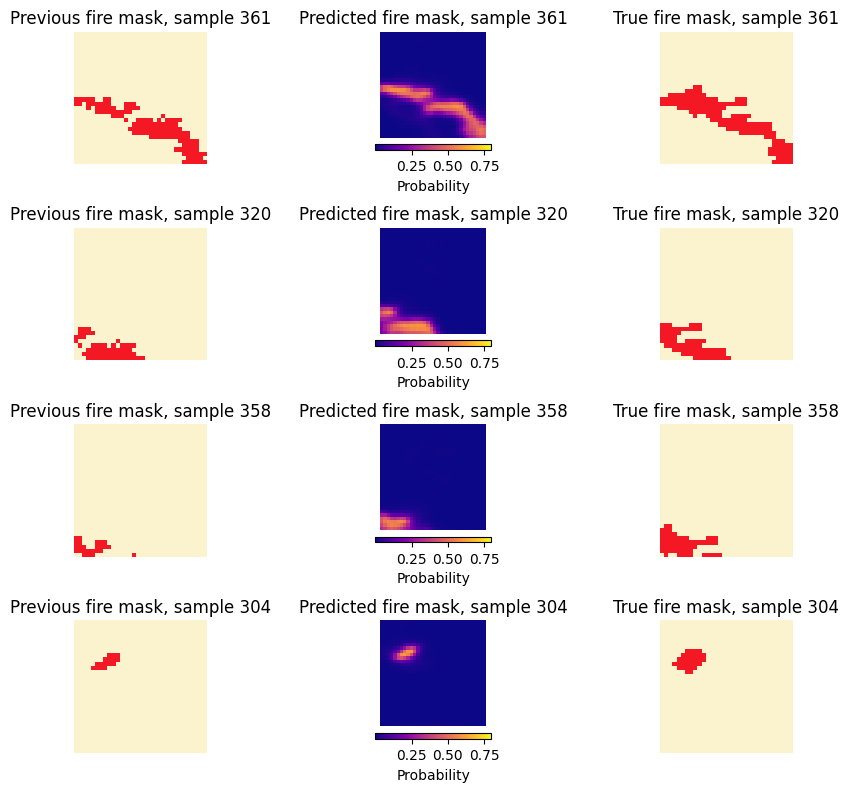

In [ ]:
# Best predictions
lit_pixels = np.count_nonzero(test_labels, axis=(1, 2)).squeeze()
errors = torch.mean(np.abs(preds_UNET.squeeze() - test_labels.squeeze()), axis=(1, 2)) / (lit_pixels + 1e-8) # compute mean by fire
N=4
best_indices = np.argsort(errors)[:N]

fig, axes = plt.subplots(nrows=N, ncols=3, figsize=(10, 2 * N))

CMAP = colors.ListedColormap(['black', "#FAF3CE", '#F41724'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
for idx, sample_index in enumerate(best_indices):
    ax = axes[idx, 0]
    ax.imshow(test_features[sample_index,:,:,-1].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Previous fire mask, sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 1]
    #ax.imshow(preds_test[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    probabilities_np = preds_UNET[sample_index].numpy()
    im = ax.imshow(probabilities_np, cmap='plasma', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(f'Predicted fire mask, sample {sample_index}')
    ax.axis('off')
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.3, pad=0.05)
    cbar.set_label('Probability')

    ax = axes[idx, 2]
    ax.imshow(test_labels[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'True fire mask, sample {sample_index}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Indices of worst predicted samples: tensor([ 55, 364,  76,  85, 200])
Errors: tensor([0.1924, 0.2002, 0.2178, 0.2578, 0.2969])


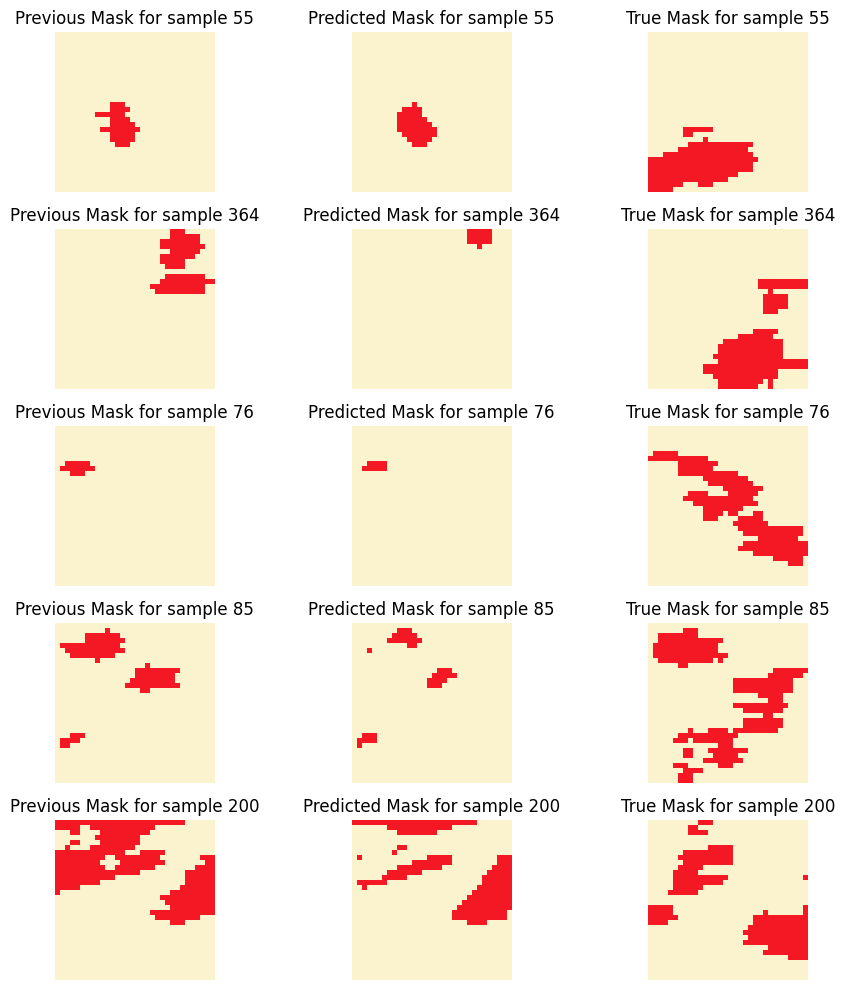

In [ ]:
# Worst predictions
worst_indices = np.argsort(errors)[-N:]

worst_errors = errors[worst_indices]
print("Indices of worst predicted samples:", worst_indices)
print("Errors:", worst_errors)

fig, axes = plt.subplots(nrows=N, ncols=3, figsize=(10, 2 * N))

CMAP = colors.ListedColormap(['black', "#FAF3CE", '#F41724'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
for idx, sample_index in enumerate(worst_indices):
    ax = axes[idx, 0]
    ax.imshow(test_features[sample_index,:,:,-1].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Previous Mask for sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 1]
    ax.imshow(preds_test[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Predicted Mask for sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 2]
    ax.imshow(test_labels[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'True Mask for sample {sample_index}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### CNN with Residual Blocks

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool(x)
        x = self.dropout(x)
        return x

class ResBlock(nn.Module):
    def __init__(self, num_filters):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.compatible = nn.Conv2d(num_filters, num_filters, kernel_size=1, padding=0)

    def forward(self, x):
        residual = self.compatible(x)
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = x + residual
        x = self.dropout1(x)
        return x

class CNN_Res(nn.Module):
    def __init__(self):
        super(CNN_Res, self).__init__()
        self.conv_block1 = ConvBlock(13, 16)
        self.conv_block2 = ConvBlock(16, 16)
        self.res_block1 = ResBlock(16)
        self.res_block2 = ResBlock(16)
        #print("here")
        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dropout1 = nn.Dropout(0.1)
        self.upconv2 = nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.final_conv = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        #print(x.shape)
        x = self.res_block1(x)
        #print(x.shape)
        x = self.res_block2(x)
        #print(x.shape)
        x = F.relu(self.upconv1(x))
        x = F.relu(self.upconv2(x))
        x = self.dropout1(x)
        x = torch.sigmoid(self.final_conv(x))
        return x

In [ ]:
# Create dataset
train_features_tensor = torch.tensor(train_features, dtype=torch.float32).permute(0, 3, 1, 2) # [batch_size, channels, height, width]
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).permute(0, 3, 1, 2)

train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=False)

val_features_tensor = torch.tensor(val_features, dtype=torch.float32).permute(0, 3, 1, 2) # [batch_size, channels, height, width]
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32).permute(0, 3, 1, 2)

val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)

test_features_tensor = torch.tensor(test_features, dtype=torch.float32).permute(0, 3, 1, 2) # [batch_size, channels, height, width]
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).permute(0, 3, 1, 2)

test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

In [ ]:
def train_model(model, data_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, t in data_loader:
            i, t = i.to(device), t.to(device)

            outputs = model(i)
            # print("Output shape:", outputs.shape)
            # print("Target shape:", targets.shape)
            loss = criterion(outputs, t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(data_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNNRes = CNN_Res().to(device)

optimizer = torch.optim.Adam(CNNRes.parameters(), lr=0.001)

#pos_weight = torch.FloatTensor([3.0]).to(device)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 5
train_model(CNNRes, train_loader, criterion, optimizer, device, num_epochs)

Epoch 1/5, Loss: 0.0444
Epoch 2/5, Loss: 0.0434
Epoch 3/5, Loss: 0.0434
Epoch 4/5, Loss: 0.0434
Epoch 5/5, Loss: 0.0434


In [ ]:
CNNRes.eval()
# !pip install torchmetrics
import torch
import torchmetrics
auc_metric = torchmetrics.AUROC(task="binary")

predictions = []
actuals = []

with torch.no_grad():
    for i, l in test_loader:
        i, l = i.to(device), l.to(device)
        outputs = CNNRes(i)
        predicted_probs = torch.sigmoid(outputs)
        predictions.extend(predicted_probs.cpu())
        actuals.extend(l)
        auc_metric.update(predicted_probs, l)
auc_score = auc_metric.compute()
predictions = torch.cat(predictions, dim=0).unsqueeze(-1)
print(f'The AUC score is: {auc_score:.4f}')

The AUC score is: 0.4994


In [ ]:
preds_test = predictions >= 0.1
# Get best and worse predictions
errors = torch.mean(np.abs(preds_test - test_labels), axis=(1, 2, 3)) # compute mean by fire
N = 5

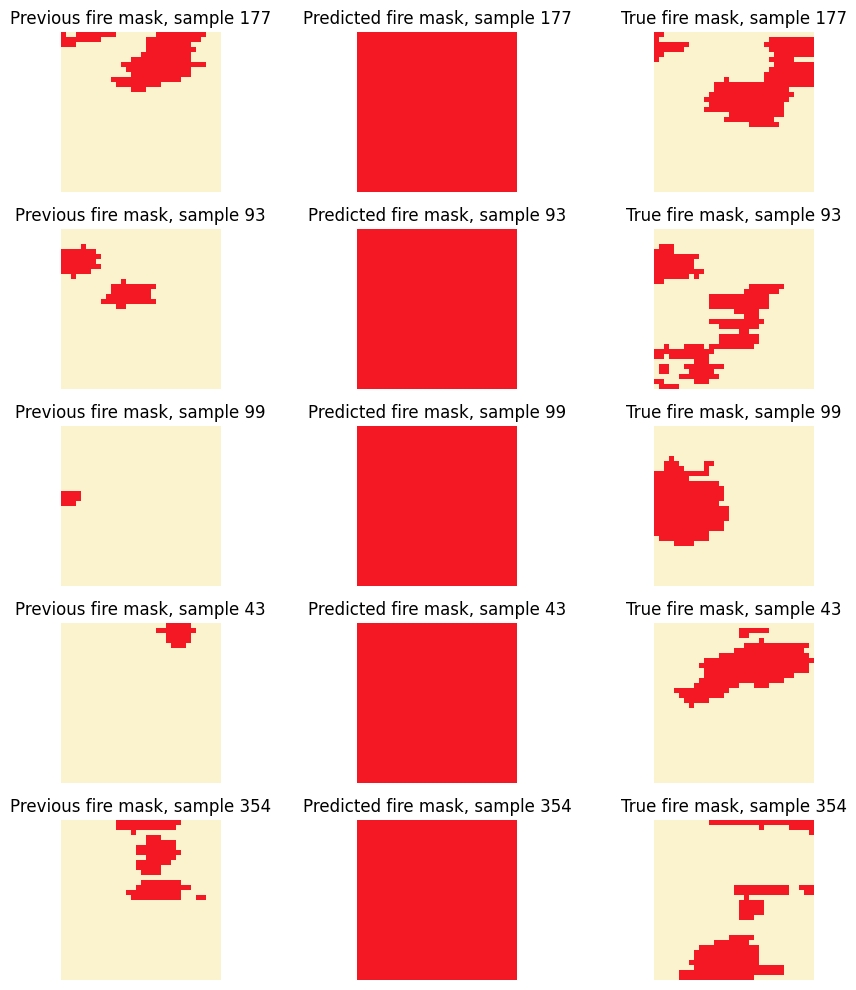

In [ ]:
# Best predictions
best_indices = np.argsort(errors)[:N]

fig, axes = plt.subplots(nrows=N, ncols=3, figsize=(10, 2 * N))

CMAP = colors.ListedColormap(['black', "#FAF3CE", '#F41724'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
for idx, sample_index in enumerate(best_indices):
    ax = axes[idx, 0]
    ax.imshow(test_features[sample_index,:,:,-1].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Previous fire mask, sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 1]
    ax.imshow(preds_test[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Predicted fire mask, sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 2]
    ax.imshow(test_labels[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'True fire mask, sample {sample_index}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Indices of worst predicted samples: tensor([313, 410, 224, 411,   2])
Errors: tensor([0.9990, 1.0000, 1.0000, 1.0000, 1.0000])


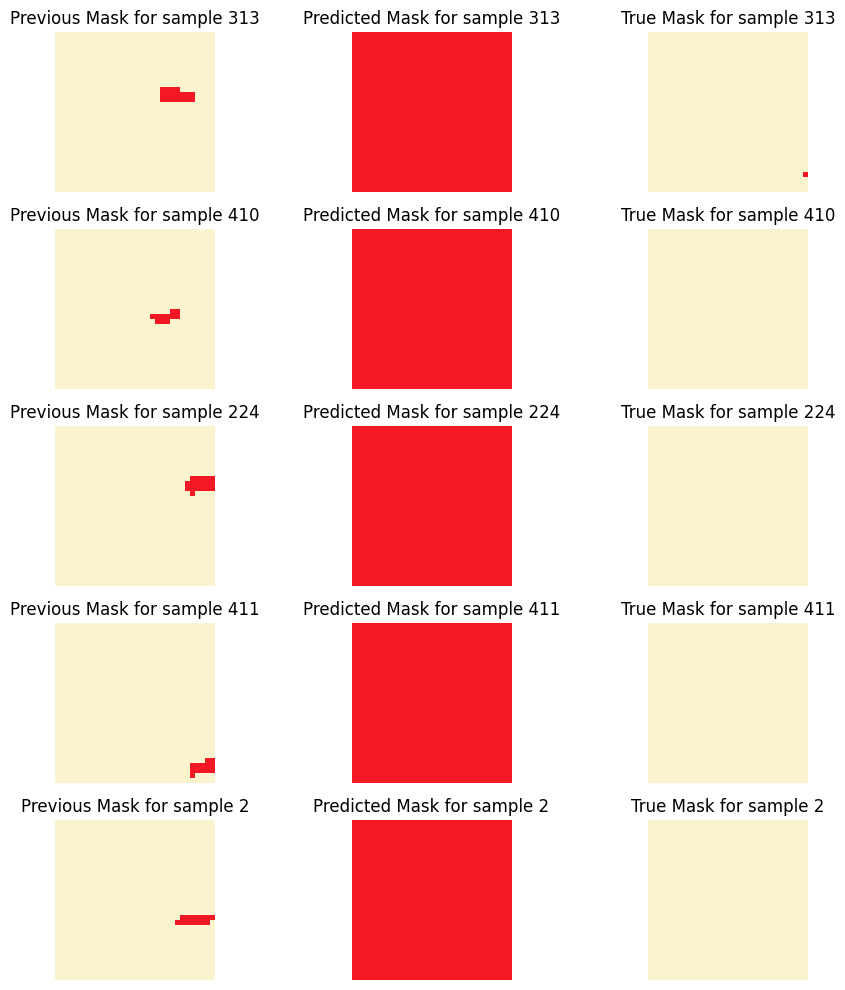

In [ ]:
# Worst predictions
worst_indices = np.argsort(errors)[-N:]

worst_errors = errors[worst_indices]
print("Indices of worst predicted samples:", worst_indices)
print("Errors:", worst_errors)

fig, axes = plt.subplots(nrows=N, ncols=3, figsize=(10, 2 * N))

CMAP = colors.ListedColormap(['black', "#FAF3CE", '#F41724'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
for idx, sample_index in enumerate(worst_indices):
    ax = axes[idx, 0]
    ax.imshow(test_features[sample_index,:,:,-1].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Previous Mask for sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 1]
    ax.imshow(preds_test[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Predicted Mask for sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 2]
    ax.imshow(test_labels[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'True Mask for sample {sample_index}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## CNN with two inputs

In [ ]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(6, 32, kernel_size=3, padding='same')
        self.pool = nn.MaxPool2d(2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')

        # Decoder
        self.t_conv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.t_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        #self.conv4 = nn.Conv2d(64, 1, kernel_size=1, padding='same')

        self.linear1 = nn.Linear(7, 32)
        self.linear2 = nn.Linear(32, 7 * 32 * 32)

        self.final_layer = nn.Conv2d(64 + 7, 1, kernel_size=1)

    def forward(self, inputs_all, inputs_mean):
        # Encoder
        # print(inputs_all.shape, inputs_mean.shape)
        inputs_all = inputs_all.to(dtype=torch.float32)
        inputs_mean = inputs_mean.to(dtype=torch.float32)
        x1 = F.relu(self.conv1(inputs_all))
        x1 = self.pool(x1)
        x1 = F.relu(self.conv2(x1))
        x1 = self.pool(x1)
        x1 = F.relu(self.conv3(x1))
        #print("input decoder", x.shape)
        # Decoder
        x1 = F.relu(self.t_conv1(x1))
        x1 = F.relu(self.t_conv2(x1))
        #x = torch.sigmoid(self.conv4(x))
        #x1 = self.conv4(x1)  # Output logits for BCEWithLogitsLoss
        x2 = F.relu(self.linear1(inputs_mean))
        x2 = F.relu(self.linear2(x2))
        x2 = x2.view(-1, 7, 32, 32)
        #print(x1.shape, x2.shape)

        x = torch.cat((x1, x2), dim=1)
        x = self.final_layer(x)
        # print(x.shape)
        #print("output ", x.shape)
        return x

In [ ]:
test_features_tensor.shape

torch.Size([472, 13, 32, 32])

In [ ]:
# Create dataset
train_features_tensor = torch.tensor(train_features, dtype=torch.float32).permute(0, 3, 1, 2) # [batch_size, channels, height, width]
train_features_tensor = torch.cat((train_features_tensor[:, 0:1, :, :], train_features_tensor[:, 8:, :, :]), dim=1) # take channels 0 and 8-12
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).permute(0, 3, 1, 2)
train_features_mean_tensor = torch.tensor([train_features[...,i].mean(axis=(1,2)) for i in(np.arange(1,8))]).permute(1, 0).to(dtype=torch.float32) # from wind direction to Precipitation
print(train_features_mean_tensor.shape)

train_dataset = TensorDataset(train_features_tensor, train_features_mean_tensor, train_labels_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=False)

val_features_tensor = torch.tensor(val_features, dtype=torch.float32).permute(0, 3, 1, 2) # [batch_size, channels, height, width]
val_features_tensor = torch.cat((val_features_tensor[:, 0:1, :, :], val_features_tensor[:, 8:, :, :]), dim=1) # take channels 0 and 8-12
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32).permute(0, 3, 1, 2)
val_features_mean_tensor = torch.tensor([val_features[...,i].mean(axis=(1,2)) for i in(np.arange(1,8))]).permute(1, 0) # from wind direction to Precipitation

val_dataset = TensorDataset(val_features_tensor, val_features_mean_tensor, val_labels_tensor)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)

test_features_tensor = torch.tensor(test_features, dtype=torch.float32).permute(0, 3, 1, 2) # [batch_size, channels, height, width]
test_features_tensor = torch.cat((test_features_tensor[:, 0:1, :, :], test_features_tensor[:, 8:, :, :]), dim=1) # take channels 0 and 8-12
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).permute(0, 3, 1, 2)
test_features_mean_tensor = torch.tensor([test_features[...,i].mean(axis=(1,2)) for i in(np.arange(1,8))]).permute(1, 0) # from wind direction to Precipitation

test_dataset = TensorDataset(test_features_tensor, test_features_mean_tensor, test_labels_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

<ipython-input-7-718f55b5670e>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  train_features_mean_tensor = torch.tensor([train_features[...,i].mean(axis=(1,2)) for i in(np.arange(1,8))]).permute(1, 0).to(dtype=torch.float32) # from wind direction to Precipitation


torch.Size([4301, 7])


In [ ]:
from operator import imatmul
def train_model_2(model, data_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for im, values, targ in data_loader:
            im, values, targ = im.to(device), values.to(device), targ.to(device)

            outputs = model(im, values)
            # print("Output shape:", outputs.shape)
            # print("Target shape:", targets.shape)
            loss = criterion(outputs, targ)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(data_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_2= CNN2().to(device)
#print(UNET)

optimizer = torch.optim.Adam(CNN_2.parameters(), lr=0.001)

#pos_weight = torch.FloatTensor([3.0]).to(device)
#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 10
train_model_2(CNN_2, train_loader, criterion, optimizer, device, num_epochs)

Epoch 1/10, Loss: 0.0119
Epoch 2/10, Loss: 0.0090
Epoch 3/10, Loss: 0.0087
Epoch 4/10, Loss: 0.0086
Epoch 5/10, Loss: 0.0085
Epoch 6/10, Loss: 0.0084
Epoch 7/10, Loss: 0.0083
Epoch 8/10, Loss: 0.0083
Epoch 9/10, Loss: 0.0082
Epoch 10/10, Loss: 0.0081


In [ ]:
CNN_2.eval()

auc_metric = torchmetrics.AUROC(task="binary")

predictions = []
actual_labels = []
# total = 0
# correct = 0

with torch.no_grad():
    for i, i_, l in test_loader:
        i, i_, l = i.to(device), i_.to(device), l.to(device)
        # print(i.shape, l.shape)
        # print(i.dtype, i_.dtype)
        outputs = CNN_2(i, i_)

        predicted_probs = torch.sigmoid(outputs) # sigmoid to convert logits to probabilities
        predictions.extend(predicted_probs.cpu())
        actual_labels.extend(l.cpu())
        # total += l.numel()
        auc_metric.update(predicted_probs, l)
        # correct += ((predicted_probs > 0.5)== l).sum().item()
auc_score = auc_metric.compute()

print(f'The AUC score is: {auc_score:.4f}')
# print(f"Accuracy: {100 * correct / total}%")
# Concatenate all batches into a single tensor
predictions = torch.cat(predictions, dim=0)
actual_labels = torch.cat(actual_labels, dim=0)

The AUC score is: 0.8854


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Save the tensor to a file in the 'my_dir' directory on Google Drive
torch.save(predictions, "/content/drive/My Drive/Computer Vision/Project/Predictions/predictions_CNN_2")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
predictions = torch.load("/content/drive/My Drive/Computer Vision/Project/Predictions/predictions_CNN_2")

(472,)
torch.Size([472])


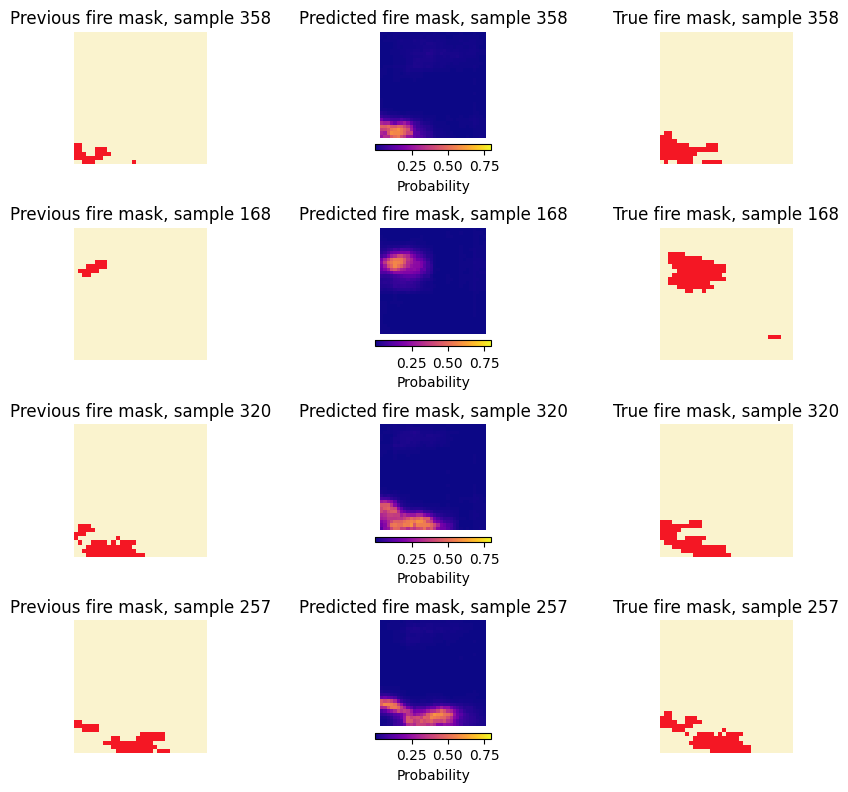

In [ ]:
# Get best and worse predictions
lit_pixels = np.count_nonzero(test_labels, axis=(1, 2)).squeeze()
errors = torch.mean(np.abs(predictions - test_labels.squeeze()), axis=(1, 2)) / (lit_pixels + 1e-8) # compute mean by fire

N = 4
best_indices = np.argsort(errors)[:N]
fig, axes = plt.subplots(nrows=N, ncols=3, figsize=(10, 2 * N))

CMAP = colors.ListedColormap(['black', "#FAF3CE", '#F41724'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
vmin = predictions.min().item()
vmax = predictions.max().item()

for idx, sample_index in enumerate(best_indices):
    ax = axes[idx, 0]
    ax.imshow(test_features[sample_index,:,:,-1].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Previous fire mask, sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 1]
    #ax.imshow(preds_test[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    probabilities_np = predictions[sample_index].numpy()
    im = ax.imshow(probabilities_np, cmap='plasma', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(f'Predicted fire mask, sample {sample_index}')
    ax.axis('off')
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.3, pad=0.05)
    cbar.set_label('Probability')

    ax = axes[idx, 2]
    ax.imshow(test_labels[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'True fire mask, sample {sample_index}')
    ax.axis('off')

plt.tight_layout()
plt.show()

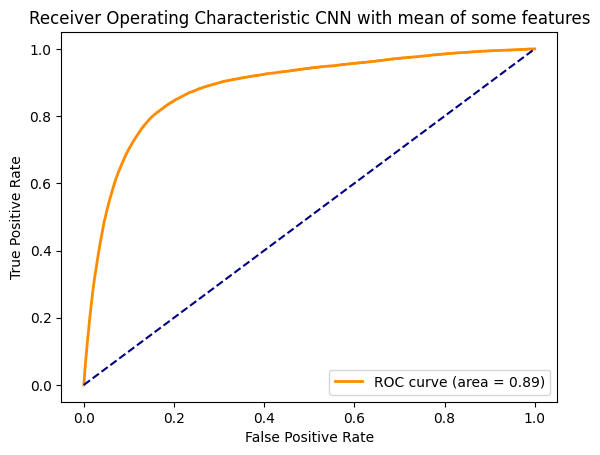

In [ ]:
import torchmetrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Flatten the tensors from [472, 32, 32] to [472*32*32]
predicted_probs_flat = predictions.view(-1)  # Flatten predicted probabilities
true_labels_flat = actual_labels.view(-1)  # Flatten true labels
predicted_probs_np = predicted_probs_flat.cpu().numpy()
true_labels_np = true_labels_flat.cpu().numpy()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels_np, predicted_probs_np)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic CNN with mean of some features')
plt.legend(loc="lower right")
plt.show()
